# Project : Data Wrangling
## Table of Contents


 
   1. Data Wrangling
   
   1. 1. Gathering data 
   1. 2. Assessing data
   
   1. 2. 1. Assess and clean at least 8 quality issues 
   1. 2. 2. Assess and clean 2 tidiness issues in this dataset.
   
   1. 3. Cleaning data
   
   2. Storing, analyzing, and visualizing your wrangled data
   



### Packages

In [146]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import time
import json
import re
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta,date
%matplotlib inline

## 1. 1. Gathering Data

In [117]:
#read archived tweets file
archive = pd.read_csv("twitter-archive-enhanced.csv", sep="," )
# Get uploaded pics
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
archive.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [87]:
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

# Read Image Predictions File as a Pandas DataFrame    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [ ]:
# credenitlas are removed upon submission
consumer_key = '
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
tweet_ids = archive.tweet_id.values
len(tweet_ids)
count = 0
fail = {}
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fail[tweet_id] = e
            pass

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [93]:
json_file = open('tweet_json.txt', "r")
tweets_data =[]
for row in json_file:
    try:
        tweet = json.loads(row)
        tweets_data.append(tweet)
    except:
        continue
json_file.close()
tweet_info = pd.DataFrame()
# Add selected variables to tweet_info DataFrame
tweet_info = pd.DataFrame(tweets_data, columns = ['id', 'favorite_count', 'retweet_count'])

In [94]:
tweet_info.head(1)

,id,favorite_count,retweet_count
0,892420643555336193,37886,8270


## 1. 2. Assess The data
### 1. 2. 1.Assess and clean at least 8 quality issues 
Quality Issues
* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets. 


We are left with non null columns. But some columns should have it's original type.

**Tidy Issues**
* tweet_id had better to be string in all dataset.
* tweet_id must all be of same name consistent

**Quality issues**

1) NaN values dropped

2) timestamp should be dataframe object. 

3) Rating numerator/denominator float. 

4) (doggo-floofer-pupper-puppo) better  all be in one variable of string in which it belongs.

5) The length of twitter archive is longer than images predictions, exclude in twitter archive the ids that are not in images prediction

6) Drop tweets with no images

7) Exclude tweets that has 0 denominator

8) remove underscore in image dataset from p1,p2,p3 columns

>  Delete not original tweet, identified by  (retweeted_status) 

In [118]:
archive[archive['retweeted_status_id'].notnull()==True]
archive.drop(archive[archive['retweeted_status_id'].notnull()== True].index,inplace=True)
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [119]:
null_columns=archive.columns[archive.isnull().any()]
null_columns

Index(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls'],
      dtype='object')

**The first quality issue:** NaN values. So The columns that have null values are 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp' and 'expanded_urls', we are gonna see the frequency of NaNs of these columns

In [120]:
archive[null_columns].isnull().sum()

in_reply_to_status_id         2097
in_reply_to_user_id           2097
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   58
dtype: int64

In [121]:
archive.drop(['retweeted_status_user_id',
               'retweeted_status_timestamp',
               'in_reply_to_status_id',
               'in_reply_to_user_id']
              ,axis=1,inplace=True)
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id               2175 non-null int64
timestamp              2175 non-null object
source                 2175 non-null object
text                   2175 non-null object
retweeted_status_id    0 non-null float64
expanded_urls          2117 non-null object
rating_numerator       2175 non-null int64
rating_denominator     2175 non-null int64
name                   2175 non-null object
doggo                  2175 non-null object
floofer                2175 non-null object
pupper                 2175 non-null object
puppo                  2175 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 161.4+ KB


In [122]:
## Performing Tidy Issue 1 tweet_id as string in archive
archive['tweet_id']=archive['tweet_id'].apply(str)
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id               2175 non-null object
timestamp              2175 non-null object
source                 2175 non-null object
text                   2175 non-null object
retweeted_status_id    0 non-null float64
expanded_urls          2117 non-null object
rating_numerator       2175 non-null int64
rating_denominator     2175 non-null int64
name                   2175 non-null object
doggo                  2175 non-null object
floofer                2175 non-null object
pupper                 2175 non-null object
puppo                  2175 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 152.9+ KB


In [123]:
## Performing Tidy Issue 1 tweet_id as string in images
image_predictions['tweet_id']=image_predictions['tweet_id'].apply(str)
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 111.5+ KB


In [124]:
##Performing quality isuue 2 string object to dataframe objects.
archive['timestamp'] = pd.to_datetime(archive['timestamp'])
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id               2175 non-null object
timestamp              2175 non-null datetime64[ns, UTC]
source                 2175 non-null object
text                   2175 non-null object
retweeted_status_id    0 non-null float64
expanded_urls          2117 non-null object
rating_numerator       2175 non-null int64
rating_denominator     2175 non-null int64
name                   2175 non-null object
doggo                  2175 non-null object
floofer                2175 non-null object
pupper                 2175 non-null object
puppo                  2175 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(9)
memory usage: 161.4+ KB


In [125]:
## Performing quality issue 3 :convert Rating numerator/denominator float.
archive['rating_numerator']=archive['rating_numerator'].apply(float)
archive['rating_denominator']=archive['rating_denominator'].apply(float)
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id               2175 non-null object
timestamp              2175 non-null datetime64[ns, UTC]
source                 2175 non-null object
text                   2175 non-null object
retweeted_status_id    0 non-null float64
expanded_urls          2117 non-null object
rating_numerator       2175 non-null float64
rating_denominator     2175 non-null float64
name                   2175 non-null object
doggo                  2175 non-null object
floofer                2175 non-null object
pupper                 2175 non-null object
puppo                  2175 non-null object
dtypes: datetime64[ns, UTC](1), float64(3), object(9)
memory usage: 161.4+ KB


In [126]:
## Performing quality issue 4: place (doggo-floofer-pupper-puppo) in one variable
archive['DoggoLingo'] = archive[['doggo', 'floofer','pupper','puppo']].apply(lambda x: ''.join(x), axis=1)
#after creating one column of four columns, we need to adjust the concatenated 4 values into one value
archive['DoggoLingo'].replace("NoneNoneNoneNone","None ", inplace=True)
archive['DoggoLingo'].replace("doggoNoneNoneNone","doggo", inplace=True)
archive['DoggoLingo'].replace("NoneflooferNoneNone","floofer", inplace=True)
archive['DoggoLingo'].replace("NoneNonepupperNone","pupper", inplace=True)
archive['DoggoLingo'].replace("NoneNoneNonepuppo","puppo", inplace=True)
archive.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id               2175 non-null object
timestamp              2175 non-null datetime64[ns, UTC]
source                 2175 non-null object
text                   2175 non-null object
retweeted_status_id    0 non-null float64
expanded_urls          2117 non-null object
rating_numerator       2175 non-null float64
rating_denominator     2175 non-null float64
name                   2175 non-null object
doggo                  2175 non-null object
floofer                2175 non-null object
pupper                 2175 non-null object
puppo                  2175 non-null object
DoggoLingo             2175 non-null object
dtypes: datetime64[ns, UTC](1), float64(3), object(10)
memory usage: 169.9+ KB


> Quality issue 5:  exclude in twitter archive the ids that are not in images prediction

In [127]:
archive = archive[archive.tweet_id.isin(image_predictions.tweet_id)]
len(archive[~archive.tweet_id.isin(image_predictions.tweet_id)])

0

> Tidy Issue 2 : Consistent columns names in in tweet dataframe

In [128]:
tweet_info.rename(index= str, columns={'id':'tweet_id'}, inplace=True)
tweet_info

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37886,8270
1,892177421306343426,32544,6111
2,891815181378084864,24507,4048
3,891689557279858688,41234,8418
4,891327558926688256,39406,9115
5,891087950875897856,19813,3030
6,890971913173991426,11580,2006
7,890729181411237888,63912,18357
8,890609185150312448,27223,4166
9,890240255349198849,31222,7184


> **Tidy Issue 1:** tweet_id needs to be string object

In [129]:
tweet_info.tweet_id = tweet_info.tweet_id.astype(str)

> Quality Issue 6: Drop tweets with no images

In [132]:
archive = archive.dropna(subset=['expanded_urls'])
archive

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,DoggoLingo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,None,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,None,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,None,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo,None,None,None,doggo


> Quality Issue 7: Exclude tweets that has 0 denominator
    

In [133]:
drop_data = archive.query('rating_denominator <= 0')
archive.drop(drop_data.index, inplace=True)

> Quality Issue 8: remove underscore in image dataset from p1,p2,p3 columns

In [134]:
image_predictions['p1'] = image_predictions['p1'].str.replace('_', ' ')
image_predictions['p2'] = image_predictions['p2'].str.replace('_', ' ')
image_predictions['p3'] = image_predictions['p3'].str.replace('_', ' ')

In [135]:
image_predictions.tweet_id = image_predictions.tweet_id.astype(str)

#### Cleaning data: Merge datatsets

In [137]:
# Merge archive and tweets dataset
merge = pd.merge(archive, tweet_info,on='tweet_id', how='inner')

In [186]:
# Merge joined dataset and image predictions
merged = pd.merge(merge,image_predictions ,on='tweet_id', how='inner')

<bound method DataFrame.info of                 tweet_id                 timestamp  \
0     892420643555336193 2017-08-01 16:23:56+00:00   
1     892177421306343426 2017-08-01 00:17:27+00:00   
2     891815181378084864 2017-07-31 00:18:03+00:00   
3     891689557279858688 2017-07-30 15:58:51+00:00   
4     891327558926688256 2017-07-29 16:00:24+00:00   
5     891087950875897856 2017-07-29 00:08:17+00:00   
6     890971913173991426 2017-07-28 16:27:12+00:00   
7     890729181411237888 2017-07-28 00:22:40+00:00   
8     890609185150312448 2017-07-27 16:25:51+00:00   
9     890240255349198849 2017-07-26 15:59:51+00:00   
10    890006608113172480 2017-07-26 00:31:25+00:00   
11    889880896479866881 2017-07-25 16:11:53+00:00   
12    889665388333682689 2017-07-25 01:55:32+00:00   
13    889638837579907072 2017-07-25 00:10:02+00:00   
14    889531135344209921 2017-07-24 17:02:04+00:00   
15    889278841981685760 2017-07-24 00:19:32+00:00   
16    888917238123831296 2017-07-23 00:22:39+00:00

In [187]:
merged.to_csv('master.csv', index=False)

### Storing, analyzing, and visualizing your wrangled data

In [188]:
master = pd.read_csv("./master.csv")
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 27 columns):
tweet_id               1992 non-null int64
timestamp              1992 non-null object
source                 1992 non-null object
text                   1992 non-null object
retweeted_status_id    0 non-null float64
expanded_urls          1992 non-null object
rating_numerator       1992 non-null float64
rating_denominator     1992 non-null float64
name                   1992 non-null object
doggo                  1992 non-null object
floofer                1992 non-null object
pupper                 1992 non-null object
puppo                  1992 non-null object
DoggoLingo             1992 non-null object
favorite_count         1992 non-null int64
retweet_count          1992 non-null int64
jpg_url                1992 non-null object
img_num                1992 non-null int64
p1                     1992 non-null object
p1_conf                1992 non-null float64
p1_dog          

> What are the top 5 popular dog names?


In [149]:
names = master['name']
count = Counter(names)
count.most_common(5)


[('None', 546), ('a', 55), ('Oliver', 10), ('Cooper', 10), ('Charlie', 10)]

Top dog names are Oliver, Cooper and charlie ten times each

> What is the most occurance source of tweet from the dtaaset

In [172]:
#source count
master.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1954
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

It's iPhone with 1954 tweets

> Which tweet had the most retweets?

In [178]:
master[master['retweet_count'] == max(master['retweet_count'])]

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
774,744234799360020481,2016-06-18 18:26:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,https://twitter.com/dog_rates/status/744234799...,13.0,10.0,None,doggo,...,1,Labrador retriever,0.825333,True,ice bear,0.044681,False,whippet,0.018442,True


> **What is the most occurance of doggolingo ?**

In [175]:
master.DoggoLingo.value_counts()

None                    1686
pupper                   203
doggo                     63
puppo                     22
doggoNonepupperNone        9
floofer                    7
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: DoggoLingo, dtype: int64

**the most dog doggolingo is pupper and its value is 203.**

> Which dogs has the lowest ratings?

In [196]:
master[master['rating_numerator']==1].head(1)


                tweet_id                  timestamp  \
1517  675153376133427200  2015-12-11 03:21:23+00:00   
1733  670783437142401025  2015-11-29 01:56:48+00:00   
1898  667549055577362432  2015-11-20 03:44:31+00:00   
1971  666287406224695296  2015-11-16 16:11:11+00:00   
1974  666104133288665088  2015-11-16 04:02:55+00:00   

                                                 source  \
1517  <a href="http://twitter.com/download/iphone" r...   
1733  <a href="http://twitter.com/download/iphone" r...   
1898  <a href="http://twitter.com" rel="nofollow">Tw...   
1971  <a href="http://twitter.com/download/iphone" r...   
1974  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
1517  What kind of person sends in a picture without...                  NaN   
1733  Flamboyant pup here. Probably poisonous. Won't...                  NaN   
1898  Never seen dog like this. Breathes heavy. Tilt...                  N

> **Is there a correlation between likes and retweets?**

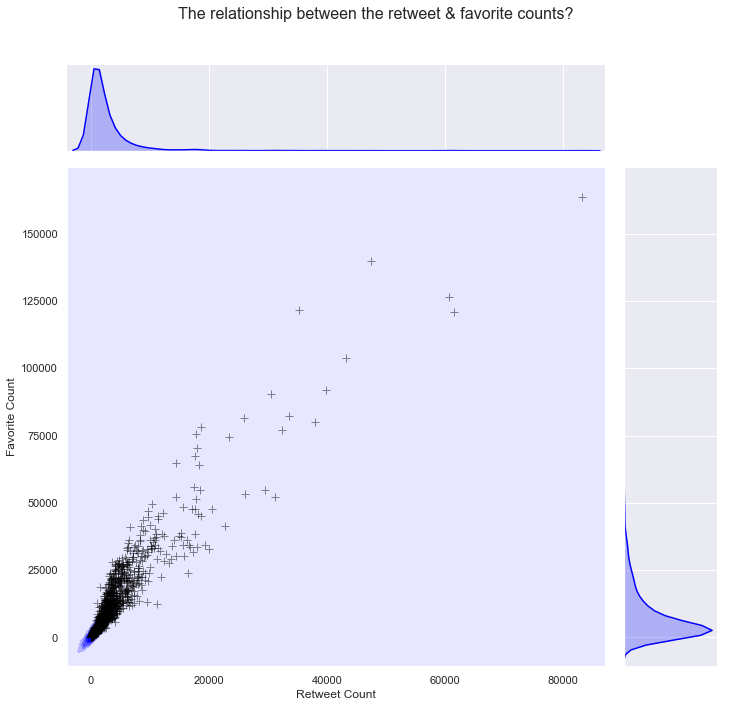

In [176]:
#Visualization comparing the favorite & retweet counts
sns.set_style('dark')
sns.set()
g = sns.jointplot(x="retweet_count", 
                  y="favorite_count", 
                  data=master, 
                  color="blue",
                  kind="kde", 
                  height=10)
g.plot_joint(plt.scatter,  
             c="black",
             s=80, 
             linewidth=1, 
             marker="+",
             alpha=0.45)
g.set_axis_labels("Retweet Count", "Favorite Count",fontsize=12)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('The relationship between the retweet & favorite counts?',
                 fontsize=16)
plt.show()

In [180]:
master['timestamp'] = pd.to_datetime(master['timestamp'])
master.set_index('timestamp', inplace=True)

Ther are aligned in the plot which makes it a strong positive correlation